# 05 - Evaluating Classification Scores of Models Submitted to the SnakeCLEF 2021 Challenge

The notebook contains validation and test scores (accuracy, f1 score and country f1 score) of models submitted to the SnakeCLEF 2021 challenge.

**Creating predictions:**
1. We train model on regular loss function (Cross Entropy)
    * We removed Flickr images from training set because they are not verified by a human anotators and some images do not contain snakes at all.
2. At test time, we utilize information about country where the image was taken and remove probabilities of species that do not live in the country.

**Model architectures used:**
* ResNeSt-101
* ResNeSt-200
* ResNet-101
* ResNeXt-101

Additionaly, as *Sumbission 5*, we created predictions using majority voting strategy. For each image the predicted species was selected based on the majority vote of *Sumbissions 1-4*. In the most of the cases (90%) three or four models had the same predicted species.

**Interesting observation:** some models (ResNext101, ResNeSt101) were trained only on mini dataset but their performance is equal (or even better) to models trained on the full dataset.

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch

from src.core import metrics
from src.utils import io, visualization as viz


DATA_DIR = 'data/snake_clef2021_dataset/'
OUTPUT_DIR = 'output/'

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Device: {device}')

Device: cpu


In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_PROD.csv')
train_df = train_df[train_df['source'] != 'flickr']

species = np.unique(train_df['binomial'])

# load country-species map, country-country LuT and rename countries
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)

# create country weight matrix
country_weights = metrics.clean_country_map(country_map_df, species=species, missing_val=0)
country_weights = torch.Tensor(country_weights.values).to(device)

In [4]:
def compute_metrics(preds, targs, country_weights):
    out = {
        'accuracy': metrics.pytorch.accuracy(preds, targs),
        'f1_score': metrics.pytorch.f1_score(preds, targs, macro=True),
        'country_f1_score': metrics.pytorch.country_f1_score(preds, targs, country_weights)}
    out = {k: v.item() for k, v in out.items()}
    return out


# load JSON with submissions
submissions_dict = io.read_json(OUTPUT_DIR + 'submission_overview.json')


# include metrics to sumbissions dict
for k, v in submissions_dict.items():
    if 'val_preds' in v:
        preds, targs = torch.load(OUTPUT_DIR + v['val_preds'])
        submissions_dict[k]['val_metrics'] = compute_metrics(preds, targs, country_weights)

# create dataframe with submissions
submissions_df = pd.DataFrame.from_dict(submissions_dict, orient='index').reset_index()
submissions_df = submissions_df.rename(columns={'index': 'submission'})
submissions_df['mini_ds_str'] = submissions_df['mini_ds'].replace(
    {True: '- Mini Dataset', np.nan: ''})
submissions_df['index'] = submissions_df.apply(
    lambda r: '{} ({}) {}'.format(r['submission'], r['model'], r['mini_ds_str']), axis=1)
submissions_df = submissions_df.set_index('index')

## Scores on Validation Set

**Note:** images from full training set and mini validation set overlap, thus Submission 4 - ResNeXt-101 has high F1 Score and Country F1 Score.

<AxesSubplot:ylabel='index'>

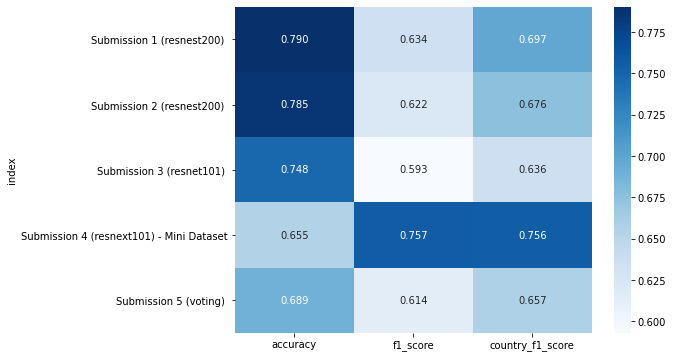

In [5]:
valid_results_df = submissions_df['val_metrics'].apply(pd.Series).dropna(axis=1, how='all')
valid_results_df = valid_results_df[['accuracy', 'f1_score', 'country_f1_score']]

fig, ax = viz.create_fig()
sns.heatmap(valid_results_df, cmap='Blues', annot=True, fmt='.3f', ax=ax)

## Scores on Test Set

<AxesSubplot:ylabel='index'>

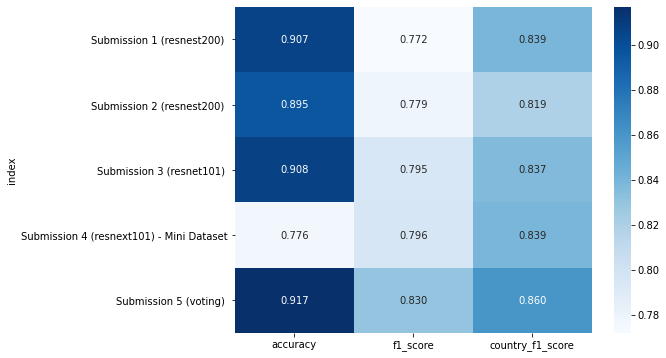

In [6]:
test_results_df = submissions_df['test_metrics'].apply(pd.Series).dropna(axis=1, how='all')
test_results_df = test_results_df[['accuracy', 'f1_score', 'country_f1_score']]

fig, ax = viz.create_fig()
sns.heatmap(test_results_df, cmap='Blues', annot=True, fmt='.3f', ax=ax)